In [1]:
import pandas as pd
economic_news_df = pd.read_csv('Full-Economic-News-DFE-839861.csv', encoding="ISO-8859-15")
economic_news_df.sample(3)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
2323,842615784,False,finalized,3,12/5/15 1:57,NaN,NaN,no,1.0000,wsj_926853429,3/9/12,Slowing Gives Beijing Room to Loosen Policy,NaN,NaN,BEIJING--A raft of economic data released on F...
6443,830984074,False,finalized,3,11/17/15 20:56,NaN,NaN,no,1.0000,wapo_138585809,6/21/85,"AT&T, Quotron Launch Financial Data System",NaN,NaN,ÐÊ\tAmerican Telephone & Telegraph Co. and Qu...
2732,842616193,False,finalized,3,12/5/15 12:32,3.0,0.3554,yes,0.6446,wsj_1543603523,7/9/14,Ahead of the Tape,NaN,NaN,Uncertainty Abounds Around Rate Rise</br></br>...


In [2]:
economic_news_df.relevance.isna().sum(), economic_news_df.text.isna().sum()

(0, 0)

In [3]:
# Drop rows with 'not sure' labels
drop_index = economic_news_df[economic_news_df.relevance == 'not sure'].index
economic_news_df.drop(index=drop_index, inplace=True)
economic_news_df.shape

(7991, 15)

In [4]:
economic_news_df = economic_news_df[['text', 'relevance']]

In [5]:
economic_news_df.sample(3)

,text,relevance
5905,"NEW YORK, March 22-The stock market sustained ...",yes
2872,Frustrated over the low returns on safe invest...,no
571,Dow Jones Newswires</br></br>WASHINGTON -- A b...,yes


In [6]:
relevance = economic_news_df['relevance'].map({'no': 0, 'yes': 1})
economic_news_df.loc[:, 'relevance'] = relevance
economic_news_df.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


In [7]:
import re
import spacy
spacy_nlp = spacy.load('en_core_web_sm')
STOPWORDS = spacy_nlp.Defaults.stop_words

In [8]:
# Clean <br> tags
def clean_br(doc):
    doc = re.sub(r'</*br>', ' ', doc)
    return doc

cleaned_text = economic_news_df['text'].map(clean_br)

In [9]:
text_filter = list(STOPWORDS) + [ '!', '"', '#', '&', '(', ')', '*', '+', '-', '.', '/',  '\\', ':', ';', '<', '=', '>',
           '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '\t','\n',"'",",",'~' , '—']

In [10]:
# $ and % sign maybe usefull in such case
'$' in text_filter

False

In [11]:
# lemmatize text with spacy
docs = spacy_nlp.pipe(cleaned_text, disable=['ner'], n_process=-1)
lemmatized_text = []
for doc in docs:
    lemmatized_text.append(' '.join([token.lemma_ for token in doc if token.lemma_ not in text_filter]))
    
lemmatized_text[:3]

['NEW YORK -- yield certificate deposit offer major bank drop tenth percentage point late week reflect overall decline short term interest rate   small denomination consumer cd sell directly bank average yield month deposit fall 5.49 % 5.62 % week end yesterday accord 18 bank survey Banxquote Money Markets Wilmington Del. information service   month consumer deposit average yield sink 5.29 % 5.42 % week accord Banxquote bank Banxquote survey Citibank New York CoreStates Pennsylvania pay 5 % threemonth small denomination cd   Declines somewhat small year consumer cd ease 7.37 % 7.45 % Banxquote   yield month month Treasury bill sell Monday auction plummet fifth percentage point previous week 5.46 % 5.63 % respectively',
 'Wall Street Journal Online   Morning Brief look day big news email subscriber 7 a.m. business day sign e mail   Friday evening Congress town summer recess Americans head mid August weekend Bush administration send message state federal government tough national child i

In [12]:
economic_news_df['lemmatized_text'] = lemmatized_text

In [13]:
from sklearn.model_selection import train_test_split
text_train, text_test, relevance_train, relevance_test = train_test_split(economic_news_df['lemmatized_text'], economic_news_df['relevance'])
len(text_train), len(relevance_test), relevance_test.sum()

(5993, 1998, 343)

In [14]:
# Check class distribution
economic_news_df['relevance'].sum()/economic_news_df.shape[0], relevance_test.sum() / len(relevance_test)

(0.17769991240145164, 0.17167167167167166)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import word_tokenize

In [16]:
sklearn_tf_vectorizer = TfidfVectorizer(tokenizer=word_tokenize)
text_train_tf = sklearn_tf_vectorizer.fit_transform(text_train)
text_test_tf = sklearn_tf_vectorizer.transform(text_test)

sklearn_ct_vectorizer = CountVectorizer(tokenizer=word_tokenize)
text_train_ct = sklearn_ct_vectorizer.fit_transform(text_train)
text_test_ct = sklearn_ct_vectorizer.transform(text_test)

text_train_tf.shape, text_test_tf.shape

((5993, 42823), (1998, 42823))

In [17]:
'$' in sklearn_tf_vectorizer.vocabulary_.keys()

True

In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(text_train_tf.toarray(), relevance_train)

y_pred_class = nb.predict(text_test_tf.toarray())
y_pred_prob = nb.predict_proba(text_test_tf.toarray())[:, 1]

print('Accuracy: ', accuracy_score(relevance_test, y_pred_class))
print('AUC: ', roc_auc_score(relevance_test, y_pred_prob))
print('F1-score: ', f1_score(relevance_test, y_pred_class))

Accuracy:  0.8033033033033034
AUC:  0.5380523724379697
F1-score:  0.18969072164948456


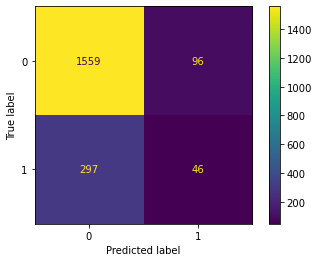

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(relevance_test, y_pred_class, labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb.classes_)
disp.plot();

In [20]:
from sklearn.naive_bayes import MultinomialNB
nb_m = MultinomialNB()
nb_m.fit(text_train_ct.toarray(), relevance_train)

ct_pred_class = nb_m.predict(text_test_ct.toarray())
ct_pred_prob = nb_m.predict_proba(text_test_ct.toarray())[:, 1]

print('Accuracy: ', accuracy_score(relevance_test, ct_pred_class))
print('AUC: ', roc_auc_score(relevance_test, ct_pred_prob))
print('F1-score: ', f1_score(relevance_test, ct_pred_class))

Accuracy:  0.7887887887887888
AUC:  0.7504487681995544
F1-score:  0.41873278236914596


In [21]:
ct_pred_class

array([0, 0, 0, ..., 0, 0, 0])

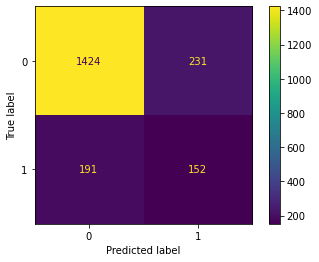

In [22]:
cm_m = confusion_matrix(relevance_test, ct_pred_class, labels=nb_m.classes_, normalize=None)
disp_m = ConfusionMatrixDisplay(confusion_matrix=cm_m,
                              display_labels=nb_m.classes_)
disp_m.plot();

In [23]:
text_train_ct.toarray().shape

(5993, 42823)

In [24]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(text_train_ct.toarray(), relevance_train)

log_pred_class = logreg.predict(text_test_ct.toarray())
log_pred_proba = logreg.predict_proba(text_test_ct.toarray())[:, 1]

print('Accuracy: ', accuracy_score(relevance_test, log_pred_class))
print('AUC: ', roc_auc_score(relevance_test, log_pred_proba))
print('F1-score: ', f1_score(relevance_test, log_pred_class))

Accuracy:  0.7582582582582582
AUC:  0.6869720697946853
F1-score:  0.32258064516129037


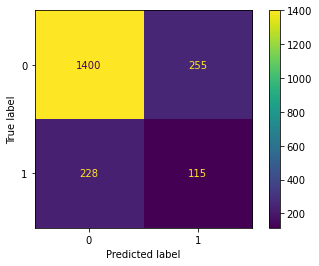

In [25]:
cm_log = confusion_matrix(relevance_test, log_pred_class, labels=logreg.classes_)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log,
                              display_labels=logreg.classes_)
disp_log.plot();

In [26]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def custom_vectorizer(vectorizer, text_train, text_test):
    train_vector = vectorizer.fit_transform(text_train)
    test_vector = vectorizer.transform(text_test)
    return train_vector, test_vector

def train_and_evaluate(model, vectorizer, text_train, text_test, relevance_train, relevance_test):
    # exception flag
    exc = None

    if vectorizer != None:
        train_vector, test_vector = custom_vectorizer(vectorizer, text_train, text_test)
        train_vector, test_vector = train_vector.toarray(), test_vector.toarray()
    else:
        train_vector, test_vector = text_train, text_test
    
    model.fit(train_vector, relevance_train)

    y_pred_class = model.predict(test_vector)
    try:
        y_pred_prob = model.predict_proba(test_vector)[:, 1]
        print('AUC: ', roc_auc_score(relevance_test, y_pred_prob))
    except Exception as exception:
        print(exception)
        exc = exception
    
    print('Accuracy: ', accuracy_score(relevance_test, y_pred_class))
    print('F1-score: ', f1_score(relevance_test, y_pred_class))

    cm = confusion_matrix(relevance_test, y_pred_class, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot();
    
    if exc is None :
        plot_roc_curve(model, test_vector, relevance_test)        

'LinearSVC' object has no attribute 'predict_proba'
Accuracy:  0.7112112112112112
F1-score:  0.32984901277584205


/home/sandro/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


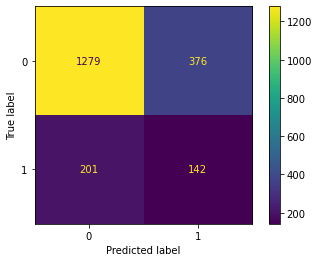

In [27]:
from sklearn.svm import LinearSVC
vectorizer = CountVectorizer(tokenizer=word_tokenize, max_features=2000)
classifier = LinearSVC(class_weight='balanced', max_iter=5000)

train_and_evaluate(model=classifier, vectorizer=vectorizer, text_train=text_train, 
                   text_test=text_test, relevance_train=relevance_train, relevance_test=relevance_test)

'LinearSVC' object has no attribute 'predict_proba'
Accuracy:  0.7027027027027027
F1-score:  0.40480961923847697


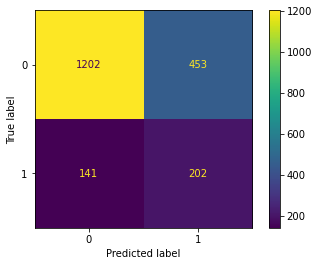

In [28]:
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, max_features=1000)
classifier = LinearSVC(class_weight='balanced', max_iter=5000)

train_and_evaluate(model=classifier, vectorizer=vectorizer, text_train=text_train, 
                   text_test=text_test, relevance_train=relevance_train, relevance_test=relevance_test)


AUC:  0.7526287511120114
Accuracy:  0.8358358358358359
F1-score:  0.2743362831858407


/home/sandro/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


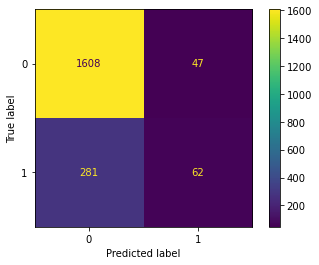

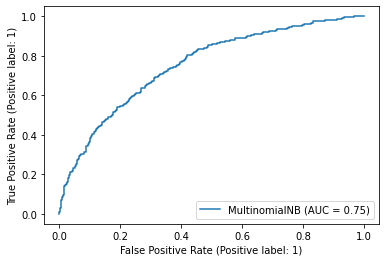

In [29]:
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, max_features=1000)
classifier = MultinomialNB()

train_and_evaluate(model=classifier, vectorizer=vectorizer, text_train=text_train, 
                   text_test=text_test, relevance_train=relevance_train, relevance_test=relevance_test)


Conclusion:

Class distribution is not equal, thats why there is the big gap between accurracy score and f1 scores. All classifiers show poor f1-score, but we made the baseline. We should find a better solution.

Let's try embeddings!

In [30]:
import gensim.downloader as api
word_vectors = api.load('word2vec-google-news-300')

In [31]:
i = 0
for k in word_vectors.key_to_index.items():
    if i < 10:
        print(k)
        i += 1
    else: break

('</s>', 0)
('in', 1)
('for', 2)
('that', 3)
('is', 4)
('on', 5)
('##', 6)
('The', 7)
('with', 8)
('said', 9)


In [32]:
word_vectors['queen'].shape

(300,)

In [33]:
docs = spacy_nlp.pipe(cleaned_text, disable=['ner'], n_process=-1)
lemmatized_list = [[word.lemma_ for word in doc] for doc in docs]
lemmatized_list[0][:10]

['NEW',
 'YORK',
 '--',
 'yield',
 'on',
 'most',
 'certificate',
 'of',
 'deposit',
 'offer']

In [34]:
len(lemmatized_list)

7991

In [35]:
import numpy as np

In [36]:
%%time
vectorized_list = np.array([np.array([word_vectors[word] for word in doc if word in word_vectors], dtype='float32') 
                            for doc in lemmatized_list])
vectorized_list.shape

CPU times: user 4.03 s, sys: 657 ms, total: 4.69 s
Wall time: 4.72 s


<timed exec>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(7991,)

In [37]:
vectorized_list.shape, vectorized_list[0][0].shape

((7991,), (300,))

In [38]:
vectorized_list = pd.Series(vectorized_list)

In [39]:
vectorized_list.map(lambda doc: doc.mean(axis=0)).shape

(7991,)

In [40]:
vectorized_list_mean = vectorized_list.map(lambda doc: doc.mean(axis=0))
vectorized_list_mean[0].shape

(300,)

In [41]:
vectorized_list_mean = np.stack(vectorized_list_mean)

In [42]:
relevance = relevance.reset_index(drop=True)

AUC:  0.7659711822418788
Accuracy:  0.6876876876876877
F1-score:  0.4526315789473684


/home/sandro/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


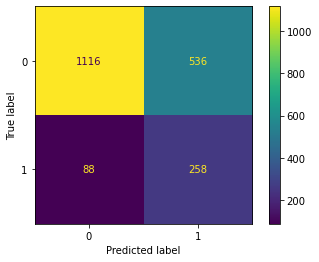

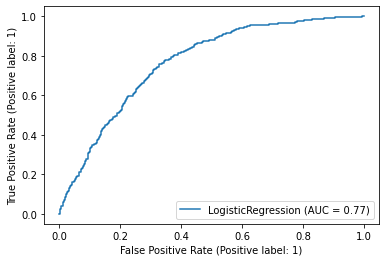

In [43]:
vectors_train, vectors_test, vec_relevance_train, vec_relevance_test = train_test_split(vectorized_list_mean, relevance)

logreg_vec = LogisticRegression(class_weight='balanced', max_iter=2000)

train_and_evaluate(model=logreg_vec, vectorizer=None, text_train=vectors_train, 
                   text_test=vectors_test, relevance_train=vec_relevance_train, relevance_test=vec_relevance_test)

AUC:  0.6270880278240423
Accuracy:  0.7777777777777778
F1-score:  0.2721311475409836


/home/sandro/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


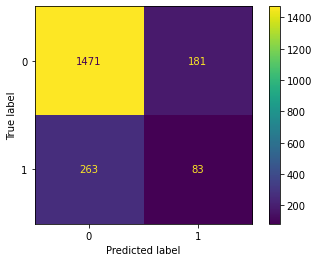

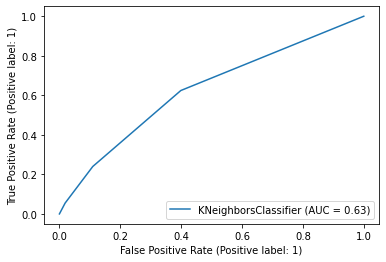

In [44]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

train_and_evaluate(model=neigh, vectorizer=None, text_train=vectors_train, 
                   text_test=vectors_test, relevance_train=vec_relevance_train, relevance_test=vec_relevance_test)


'LinearSVC' object has no attribute 'predict_proba'
Accuracy:  0.6926926926926927
F1-score:  0.4537366548042705


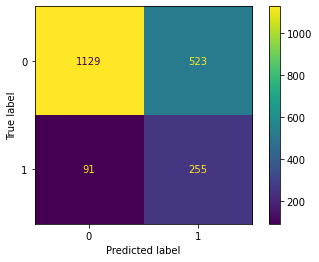

In [45]:
from sklearn.svm import LinearSVC

svc_classifier = LinearSVC(class_weight='balanced', max_iter=3000)

train_and_evaluate(model=svc_classifier, vectorizer=None, text_train=vectors_train, 
                   text_test=vectors_test, relevance_train=vec_relevance_train, relevance_test=vec_relevance_test)

Let's try Fasttext

In [46]:
import fasttext
economic_news_df['labels'] = '__label__' + economic_news_df['relevance'].astype(str)

In [47]:
fastt_train, fastt_test, fastt_label_train, fastt_label_test = train_test_split(economic_news_df['lemmatized_text'], economic_news_df['labels'])
fastt_train[:10]

2206    NEW YORK -- dissent vote year Federal Reserve ...
7610    NEW YORK Jan. 6ûóthe stock market push rally ...
3694    Conde Nast Publications Inc. absorb nearly dec...
985     MAY STORES propose acquire Associated Dry Good...
5874    steel industry hit massive layoff plant closin...
5783    NEW YORK March 30 ap)ûóthe stock market post ...
2869    dutch supermarket group Ahold NV acquire remai...
7063    .View yojfk. Fcl 26 apiûóthe stock market slu...
2564    smart analyst warn year fall surging bond mark...
4823    number worker injure zero number dead zero fac...
Name: lemmatized_text, dtype: object

In [48]:
train_df_temp = fastt_label_train + ' ' + fastt_train
train_df_temp[:10]

2206    __label__0 NEW YORK -- dissent vote year Feder...
7610    __label__0 NEW YORK Jan. 6ûóthe stock market ...
3694    __label__0 Conde Nast Publications Inc. absorb...
985     __label__1 MAY STORES propose acquire Associat...
5874    __label__1 steel industry hit massive layoff p...
5783    __label__1 NEW YORK March 30 ap)ûóthe stock m...
2869    __label__0 dutch supermarket group Ahold NV ac...
7063    __label__0 .View yojfk. Fcl 26 apiûóthe stock...
2564    __label__0 smart analyst warn year fall surgin...
4823    __label__0 number worker injure zero number de...
dtype: object

In [49]:
test_df_temp = fastt_label_test + ' ' + fastt_test
test_df_temp[:10]

2367    __label__0 author Robert Guy Matthews   impact...
4880    __label__0 head respective antitrust agency es...
3055    __label__0 job debate heat week White House ex...
4360    __label__0 rise energy price push U.S. consume...
3696    __label__0 stock price climb modestly despite ...
4063    __label__0 average interest rate 30 year fix r...
6848    __label__1 NEW YORK June 18 ap)ûómotor active...
7432    __label__0 consumer price continue rise 6 cent...
4182    __label__0 nationÛªs bank regulator involve c...
4815    __label__0 manufacturing sector strong month m...
dtype: object

In [50]:
with open('fastt_test_data', mode='a') as f:
    [f.write(f'{line}\n') for line in test_df_temp]

In [2]:
# import csv
# test_df_temp.to_csv('fastt_test_data', header=None, index=None, sep=' ', mode='a', quoting=csv.QUOTE_NONE)

In [51]:
with open('fastt_train_data', mode='a') as f:
    [f.write(f'{line}\n') for line in train_df_temp]

In [52]:
fast_model = fasttext.train_supervised(
    input="fastt_train_data", 
    label="__label__", 
    lr=1.0, 
    epoch=75, 
    loss='ova', 
    wordNgrams=3, 
    dim=300, 
    thread=2, 
    verbose=100)

Read 0M words
Number of words:  47546
Number of labels: 2
Progress: 100.0% words/sec/thread:  342225 lr:  0.000000 avg.loss:  0.028096 ETA:   0h 0m 0s  0h 1m 8s 6s 0.902067 ETA:   0h 1m 5s  2.7% words/sec/thread:  436680 lr:  0.973073 avg.loss:  0.794146 ETA:   0h 1m 5s  6.9% words/sec/thread:  439469 lr:  0.930739 avg.loss:  0.372849 ETA:   0h 1m 1s  8.6% words/sec/thread:  440331 lr:  0.914011 avg.loss:  0.304420 ETA:   0h 1m 0s 10.3% words/sec/thread:  440825 lr:  0.897296 avg.loss:  0.256854 ETA:   0h 0m59s 11.0% words/sec/thread:  440676 lr:  0.889783 avg.loss:  0.239784 ETA:   0h 0m59s 11.8% words/sec/thread:  440720 lr:  0.882226 avg.loss:  0.225506 ETA:   0h 0m58s 440728 lr:  0.874677 avg.loss:  0.212429 ETA:   0h 0m58s 13.3% words/sec/thread:  440563 lr:  0.867178 avg.loss:  0.200621 ETA:   0h 0m57s 14.0% words/sec/thread:  440626 lr:  0.859618 avg.loss:  0.190165 ETA:   0h 0m57s 14.8% words/sec/thread:  440613 lr:  0.852069 avg.loss:  0.180893 ETA:   0h 0m56s 15.6% words/sec/

In [59]:
test_df_temp[3990]

'__label__1 volatility Wall Street phenomenon hit Main Street   far incoming September economic report surprisingly firm auto sale rebound high level April chain store sale post year year growth 5.5 % economy add 103,000 job manufacturing sentiment improve bit Friday Commerce Department figure expect strong 0.8 % monthly increase retail food service sale consumer sentiment brightening attitude   feel like 180 degree turn August basically thing special case broad turning point jerky swing norm consider happen far year real gross domestic product shrink January February accord track firm Macroeconomic Advisers surge 1 % March contract May June -- jump 1 % July   typical 1992 monthly gdp fall time economy recession year assume small gain August monthly gdp fall half time common gdp growth 1 % month usually happen year half 2011 happen twice   surprise stock swinge wildly sink shy bear market territory S&P 500 jump nearly 8 % trading session Thursday rally predicate figure U.S. likely avoi

In [60]:
fast_model.predict(test_df_temp[3990], k=2)

(('__label__0', '__label__1'), array([0.9603712 , 0.03847619]))

In [61]:
for k in range(1,3):
    results = fast_model.test("fastt_test_data",k=k)
    print(f"Test Samples: {results[0]} Precision@{k} : {results[1]*100:2.4f} Recall@{k} : {results[2]*100:2.4f}")

Test Samples: 1998 Precision@1 : 80.8809 Recall@1 : 80.8809
Test Samples: 1998 Precision@2 : 50.0000 Recall@2 : 100.0000


In [66]:
economic_news_df[economic_news_df['relevance'] == 1].text[:10]

0     NEW YORK -- Yields on most certificates of dep...
4     NEW YORK -- Indecision marked the dollar's ton...
5     Stocks declined, as investors weighed slower-t...
9     The U.S. dollar declined against most major fo...
12    Author: James B. Stewart</br></br>The dreaded ...
17    NEW YORK -- The dollar sagged yesterday, as ne...
20    The technology industry, an engine of innovati...
21    WASHINGTON -- While acknowledging that the pac...
27    WASHINGTON -- In a sign that inflation remains...
30    WASHINGTON -- Consumer credit in July continue...
Name: text, dtype: object

In [71]:
# fasttext show better performance but does it?
conf_yes = [int(fast_model.predict(doc)[0][0][-1]) for doc in economic_news_df[economic_news_df['relevance'] == 1].text]
conf_yes = pd.Series(conf_yes)
conf_yes.mean()

0.3

In [72]:
conf_no = [int(fast_model.predict(doc)[0][0][-1]) for doc in economic_news_df[economic_news_df['relevance'] == 0].text]
conf_no = pd.Series(conf_no)
conf_no.mean()

0.01765332521686197